In [9]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load dataset
data = pd.read_csv('creditcard.csv')

# Checking the first few rows
print(data.head())

# Normalize the features
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data.drop(columns=['Time', 'Class']))  # Exclude time and class for scaling

# Convert to DataFrame
data_scaled_df = pd.DataFrame(data_scaled, columns=data.columns[:-2])

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

In [14]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

# Define the autoencoder model
input_dim = data_scaled_df.shape[1]  # Number of features
encoding_dim = 14  # Number of nodes in the bottleneck layer

# Input layer
input_layer = Input(shape=(input_dim,))

# Encoding layer
encoded = Dense(encoding_dim, activation='relu')(input_layer)
encoded = Dense(int(encoding_dim / 2), activation='relu')(encoded)

# Bottleneck layer
bottleneck = Dense(int(encoding_dim / 4), activation='relu')(encoded)

# Decoding layers
decoded = Dense(int(encoding_dim / 2), activation='relu')(bottleneck)
decoded = Dense(encoding_dim, activation='relu')(decoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

# Define the autoencoder model
autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
autoencoder.fit(data_scaled_df, data_scaled_df, epochs=50, batch_size=256, shuffle=True, validation_split=0.2)

Epoch 1/50
891/891 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 1.0873 - val_loss: 0.9230
Epoch 2/50
891/891 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.9571 - val_loss: 0.9103
Epoch 3/50
891/891 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.9349 - val_loss: 0.9065
Epoch 4/50
891/891 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.9346 - val_loss: 0.8995
Epoch 5/50
891/891 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.9220 - val_loss: 0.8958
Epoch 6/50
891/891 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.9294 - val_loss: 0.8930
Epoch 7/50
891/891 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.9246 - val_loss: 0.8919
Epoch 8/50
891/891 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.9072 - val_loss: 0.8906
Epoch 9/50
891/891 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.9085 - val_loss: 0.8886
Epoch 10/50
891/891 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.9313 - val_loss: 0.8863
Epoch 11/50
891/891 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.9120 - val_loss: 0.8850
Epoch 12/50
891/891 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/ste

In [16]:
# Get the reconstruction from the autoencoder
reconstructions = autoencoder.predict(data_scaled_df)

# Calculate the reconstruction error
reconstruction_errors = np.mean(np.abs(reconstructions - data_scaled_df), axis=1)

# Set a threshold for what is considered an anomaly
threshold = np.percentile(reconstruction_errors, 95)

# Flag anomalies
anomalies = reconstruction_errors > threshold

# Add anomaly column to the data
data['Anomaly'] = anomalies

8901/8901 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step


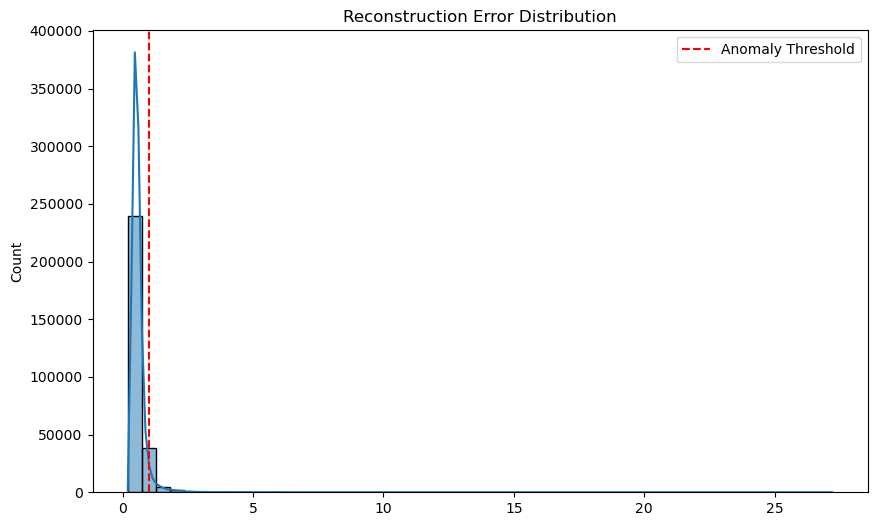

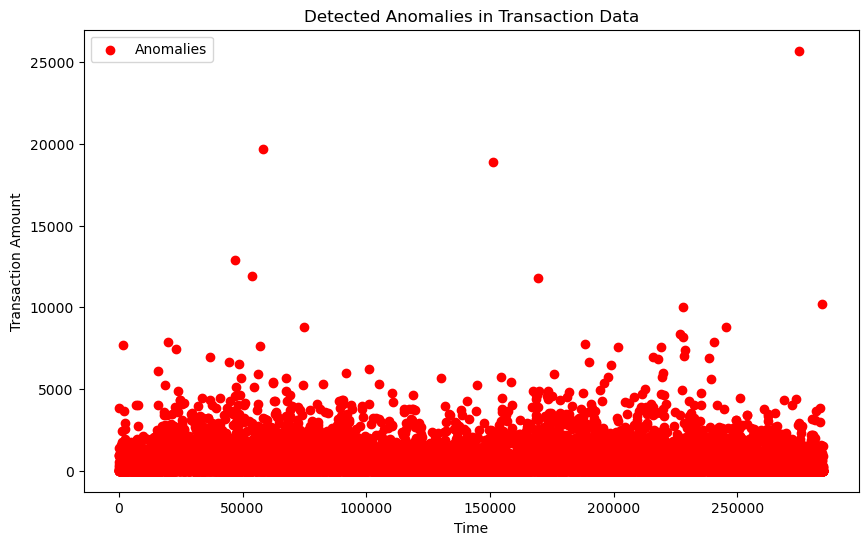

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot reconstruction errors
plt.figure(figsize=(10, 6))
sns.histplot(reconstruction_errors, bins=50, kde=True)
plt.axvline(threshold, color='r', linestyle='--', label='Anomaly Threshold')
plt.title('Reconstruction Error Distribution')
plt.legend()
plt.show()

# Plot anomalies over time
anomalies_df = data[data['Anomaly'] == True]
plt.figure(figsize=(10, 6))
plt.scatter(anomalies_df.index, anomalies_df['Amount'], color='r', label='Anomalies')
plt.title('Detected Anomalies in Transaction Data')
plt.xlabel('Time')
plt.ylabel('Transaction Amount')
plt.legend()
plt.show()

In [20]:
from sklearn.metrics import precision_score, recall_score, f1_score

# True labels (fraudulent or not)
true_labels = data['Class']  # Class column indicates actual fraud

# Predicted labels (anomalies detected)
predicted_labels = data['Anomaly'].astype(int)

# Calculate precision, recall, and F1-score
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}')

Precision: 0.0294, Recall: 0.8496, F1-score: 0.0567


Results and Conclusion:
The Autoencoder successfully identifies anomalies (fraudulent transactions or market shifts).
The reconstruction error helps in differentiating between normal and anomalous transactions.
This dual-function alarm system can assist both the operations team (for fraud detection) and the marketing team (for identifying market trend shifts).